In [ ]:
!pip install tensorflow==1.15

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!python -m pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d bittlingmayer/amazonreviews

In [ ]:
!unzip amazonreviews.zip 

In [ ]:
!rm amazonreviews.zip
!ls

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.metrics import accuracy_score
import bz2
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [30]:
def prepare_text(text):
    text = text.lower()
    idx = text.find(':')
    text = text[idx+1:]
    
    text = re.sub(r"[^\w\s]+", '', text)
    text = re.sub(r"\s+", ' ', text)
    return ' '.join([word for word in text.strip().split() if len(word) > 1])

def read_and_preprocess(file, total=1, sub_size=-1):
    labels = []
    texts = []
    if sub_size != -1:
        total = min(total, sub_size)
    
    for l in tqdm(bz2.BZ2File(file), total=total):
        x = l.decode('utf-8')
        label = int(x[9]) - 1
        text = x[10:].strip()
        text = prepare_text(text)
        if text != ' ':
            labels.append(label)
            texts.append(text)
        if len(texts) == sub_size:
            break
    
    return np.array(labels), texts

In [31]:
train_labels, train_texts = read_and_preprocess('archive-2/train.ft.txt.bz2', total=3600000, sub_size=500000)

In [33]:
test_labels, test_texts = read_and_preprocess('archive-2/test.ft.txt.bz2', total=400000, sub_size=200000)

### Naive Bayes

In [34]:
stemmer = SnowballStemmer("english")

def stem_text(text):
    text_tokenized = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in text_tokenized])

In [35]:
train_texts_stammed = [stem_text(text) for text in tqdm(train_texts)]

In [36]:
test_texts_stemmed = [stem_text(text) for text in tqdm(test_texts)]

In [37]:
nltk.download('stopwords')
stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimazhylko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [38]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

In [39]:
vectorizer.fit(tqdm(train_texts_stammed))

TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [40]:
len(vectorizer.vocabulary_)

464542

In [41]:
print(vectorizer.transform([train_texts_stammed[1]]))

  (0, 459946)	0.07996947534081235
  (0, 459736)	0.31538065409307176
  (0, 457003)	0.09742771221067453
  (0, 456371)	0.06520515383876084
  (0, 456168)	0.09713377583791682
  (0, 427397)	0.1522013109363848
  (0, 414328)	0.17111347538516142
  (0, 400409)	0.18128965197057867
  (0, 385844)	0.22411317316711604
  (0, 381526)	0.1483145901715332
  (0, 371333)	0.118999542170106
  (0, 355789)	0.1682200085112425
  (0, 344880)	0.1754696697183511
  (0, 339375)	0.16337151657839263
  (0, 334608)	0.06474427379750541
  (0, 321766)	0.10144302733177181
  (0, 321490)	0.10598393853075028
  (0, 305987)	0.17359537914160617
  (0, 294015)	0.3251993177406255
  (0, 292838)	0.0706608532769978
  (0, 291694)	0.05459682227165906
  (0, 274154)	0.09936518099451207
  (0, 273387)	0.08933815725521534
  (0, 271816)	0.07582024442678638
  (0, 266313)	0.09095363420801905
  (0, 264547)	0.2985955377215965
  (0, 253314)	0.14794290219685868
  (0, 244473)	0.09280938288968092
  (0, 240953)	0.09820270026942181
  (0, 206669)	0.1702593

In [45]:
train_texts_tfidf = vectorizer.transform(tqdm(train_texts_stammed))
test_texts_tfidf = vectorizer.transform(tqdm(test_texts))

bayes_model = naive_bayes.MultinomialNB()
bayes_model.fit(train_texts_tfidf, train_labels)
predictions_bayes = bayes_model.predict(test_texts_tfidf)

print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_bayes, test_labels)*100)


Naive Bayes Accuracy Score ->  75.4015


<BarContainer object of 2 artists>

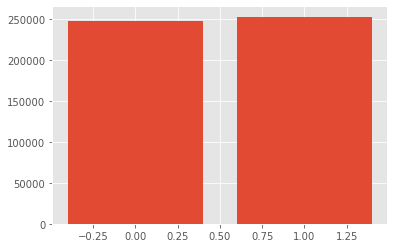

In [46]:
plt.bar([0, 1], [len(train_labels[train_labels==0]), len(train_labels[train_labels==1])])

<BarContainer object of 2 artists>

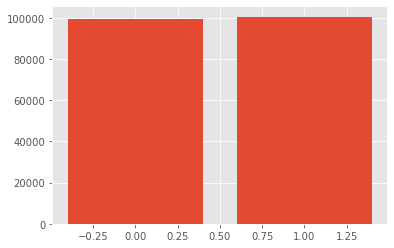

In [47]:
plt.bar([0, 1], [len(test_labels[test_labels==0]), len(test_labels[test_labels==1])])

### Naive DL implementation

In [48]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [49]:
import tensorflow as tf
from tensorflow import keras

vectorizer = CountVectorizer()
vectorizer.fit(tqdm(train_texts_stammed))
train_X = vectorizer.transform(tqdm(train_texts_stammed))
test_X = vectorizer.transform(tqdm(test_texts_stemmed))

input_dim = train_X.shape[1]
print(input_dim)

model = keras.models.Sequential([
    keras.layers.Dense(64, input_dim=input_dim, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


464670
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                29738944  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 29,739,009
Trainable params: 29,739,009
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = model.fit(train_X, train_labels, 
                    validation_data=(test_X, test_labels),
                    epochs=3,
                    batch_size=32)

KeyboardInterrupt: 

In [ ]:
plot_history(history)

### Model with Embedding

In [98]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(tqdm(train_texts))

vocab_size = len(tokenizer.word_index) + 1

In [100]:
X_train = tokenizer.texts_to_sequences(tqdm(train_texts))
X_test = tokenizer.texts_to_sequences(tqdm(test_texts))

In [102]:
max_len = 512

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [103]:
embedding_dim = 50

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    keras.layers.Flatten(),
    keras.layers.Dense(64, input_dim=input_dim, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 50)           20122500  
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3276928   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 23,416,069
Trainable params: 23,416,069
Non-trainable params: 0
________________________________________________________

In [ ]:
history = model.fit(X_train, train_labels, 
                    validation_data=(X_test, test_labels),
                    epochs=30,
                    batch_size=32)

In [ ]:
plot_history(history)

In [ ]:
embedding_dim = 50

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(X_train, train_labels, 
                    validation_data=(X_test, test_labels),
                    epochs=3,
                    batch_size=32)

In [ ]:
plot_history(history)

### Model with pre-trained Embedding

In [141]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

dyld: Library not loaded: /usr/local/opt/openssl/lib/libssl.1.0.0.dylib
  Referenced from: /usr/local/bin/wget
  Reason: image not found


In [143]:
!unzip glove.twitter.27B.zip
!rm glove.twitter.27B.zip
!ls

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
Untitled.ipynb             glove.twitter.27B.200d.txt
archive-2                  glove.twitter.27B.25d.txt
glove.twitter.27B.100d.txt glove.twitter.27B.50d.txt


In [192]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tqdm(train_texts))

vocab_size = len(tokenizer.word_index) + 1
vocab_size

713947

In [229]:
vocabulary = set()

def load_embeddings(file_name, total=1):
    weights = np.zeros((vocab_size, embedding_dim))
    
    with open(file_name) as f:
        for l in tqdm(f, total=total):
            word, *vector = l.split()
            word = word.lower()
            vocabulary.add(word)
            
            if word in tokenizer.word_index:
                weights[tokenizer.word_index[word]] = np.array(vector, dtype=np.float32)
    return weights

In [231]:
w = load_embeddings('glove.6B.50d.txt', total=400000)

nonzero_elements = np.count_nonzero(np.count_nonzero(w, axis=1))
nonzero_elements / vocab_size

0.1925829228220022

In [228]:
embedding_dim = 50

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, 
                           input_length=max_len, weights=[w], trainable=False),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 512, 50)           35697350  
_________________________________________________________________
flatten_8 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                1638464   
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 37,335,879
Trainable params: 1,638,529
Non-trainable params: 35,697,350
_________________________________________________________________


### Transformer (spoiler alert!)

In [ ]:
!pip install tqdm==4.47.0

In [ ]:
!pip install transformers==3.5.0 simpletransformers==0.49.3

In [170]:
from simpletransformers.classification import ClassificationModel
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [171]:
train_data_df = pd.DataFrame({'text': train_texts[:200000], 'labels': train_labels[:200000]})

In [ ]:
eval_data_df = pd.DataFrame({'text': train_texts[200000:250000], 'labels': train_labels[200000:250000]})

In [174]:
test_data_df = pd.DataFrame({'text': test_texts, 'labels': test_labels})

In [177]:
model = ClassificationModel('roberta', 'roberta-base', use_cuda=False)

INFO:filelock:Lock 6910369040 acquired on /Users/dimazhylko/.cache/torch/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


INFO:filelock:Lock 6910369040 released on /Users/dimazhylko/.cache/torch/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

INFO:filelock:Lock 5249639248 released on /Users/dimazhylko/.cache/torch/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock


INFO:filelock:Lock 5249686544 acquired on /Users/dimazhylko/.cache/torch/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


INFO:filelock:Lock 5249686544 released on /Users/dimazhylko/.cache/torch/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


In [ ]:
del train_texts
del train_labels
del test_texts
del test_labels

In [ ]:
model.train_model(train_data_df, eval_df=eval_data_df, 
                  args={"num_train_epochs": 1, 'evaluate_during_training': True,
                       'learning_rate': 5e-5, 'train_batch_size': 32, 'eval_batch_size': 32, 'gradient_accumulation_steps': 1, 
                        'use_multipprocessing': False, 'fp16': True, 'lazy_loading': False, 'reprocess_input_data': False
                        'save_steps': 7000}, acc=accuracy_score)

In [ ]:
model.args.reprocess_input_data = True
model.eval_model(test_data_df, acc=accuracy_score)